(pvalue)=
# p-value from simulation

## New York City Jury Demographics

The goal of the following simulation is to determine whether the difference between NYC jury demographics in 2007 and those recorded in the 2000 US could be due to randomness.

Sources:
+ https://ppefny.org/2007/06/racial-and-ethnic-disparity-in-manhattan-jury-pools-results-of-a-survey-and-suggestions-for-reform/474
+ https://ppefny.org/wp-content/uploads/2007/06/200706RJJuryPoolStudy.pdf

*Note:* The methodology of this survey has significant flaws:
"Our researchers simply noted the apparent race and apparent Hispanic status of each prospective juror in each jury assembly room and tallied the results."

Other reading/references: https://www.nytimes.com/2007/06/27/nyregion/27jurors.html

### Step 1 - Demographics Distance

- Create a `demographics` data frame that contains the racial and ethnic demographics NYC as recorded by the 2000 US census and those of the NYC Juries as reported by the 2007 survey cited below. 

In [ ]:
library(ggplot2)
library(dplyr)

In [14]:
demographics <- data.frame(
    group = c('white', 'black', 'asian', 'other'),
    census = c(54.4, 17.4, 9.5, 18.8), 
    jury_pool = c(77.7, 10.1, 6.5, 5.7)
    ) %>%
    arrange(group)
demographics

group,census,jury_pool
<chr>,<dbl>,<dbl>
asian,9.5,6.5
black,17.4,10.1
other,18.8,5.7
white,54.4,77.7


## Step 2: Compute the observed distance

- Compute the distance between the jury pool demographics and those recored in by the census. 

In [27]:
# compute distances
demographics <- mutate(demographics, difference = census - jury_pool)
observed_distance <- sum(abs(demographics$difference))
observed_distance

[1] 46.7

The distance is not zero. The question is whether or not this is due to randomness.

## Step 3: Run simulation

 - Simulate randomly choosing 100 people for a jury pool 1000 times. 

In [23]:
# simulation
num_simulations <- 1000
pool_size <-  100 # using "pool" instead of "trial" due to context
total_samples <- num_simulations * pool_size

all_samples <- demographics %>%
    select(group) %>% # reduce memory use by selecting the relavant column
    sample_n( 
                total_samples, 
                replace = TRUE,
                weight = demographics$census/100 # proportions
    ) %>%
    mutate(
        pool = rep(1:num_simulations, each = pool_size)
    )
    
nrow(all_samples) # check that there are 100,000 samples
max(all_samples$pool) # check that max pool number is 1000

[1] 100000

[1] 1000

## Step 4: Analyze the simulation

- Create a summary table that has a row for each pool in the simulation and shows the percentage of jurors in each pool that belong to each racial group. 
- Compute the distance between the demographics of each simulated jury pool and those of the census.

In [47]:
# Recall order of racial groups
demographics$group

[1] "asian" "black" "other" "white"

In [37]:
# proportions
proportions <- all_samples %>%
    group_by(pool) %>%
    summarize( # compute percentages for each pool
        perc_asian = mean(group=='asian')*100,
        perc_black = mean(group=='black')*100,
        perc_other = mean(group=='other')*100,
        perc_white = mean(group=='white')*100
    ) %>%
    mutate( # compute the distance between each pool and the census
        distance =
            abs(perc_asian - demographics$census[1]) +
            abs(perc_black - demographics$census[2]) +
            abs(perc_other - demographics$census[3]) +
            abs(perc_white - demographics$census[4])
    )

head(proportions, 3)

pool,perc_asian,perc_black,perc_other,perc_white,distance
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,15,13,14,58,18.3
2,10,10,21,59,14.7
3,13,16,12,59,16.3


In [39]:
# Range of differences
min(proportions$distance)
max(proportions$distance)

[1] 1.5

[1] 37.3

Randomness leads to a variety of different distances.

## Step 5: Find the p-value

The p-value is the proportion of simulations that are further from the hypothesis (census demographics) than the observed data. 

In [48]:
p_value <- mean(proportions$distance > observed_distance)
p_value

[1] 0

0% of the simulations have are further from the census data than the actual jury pools.

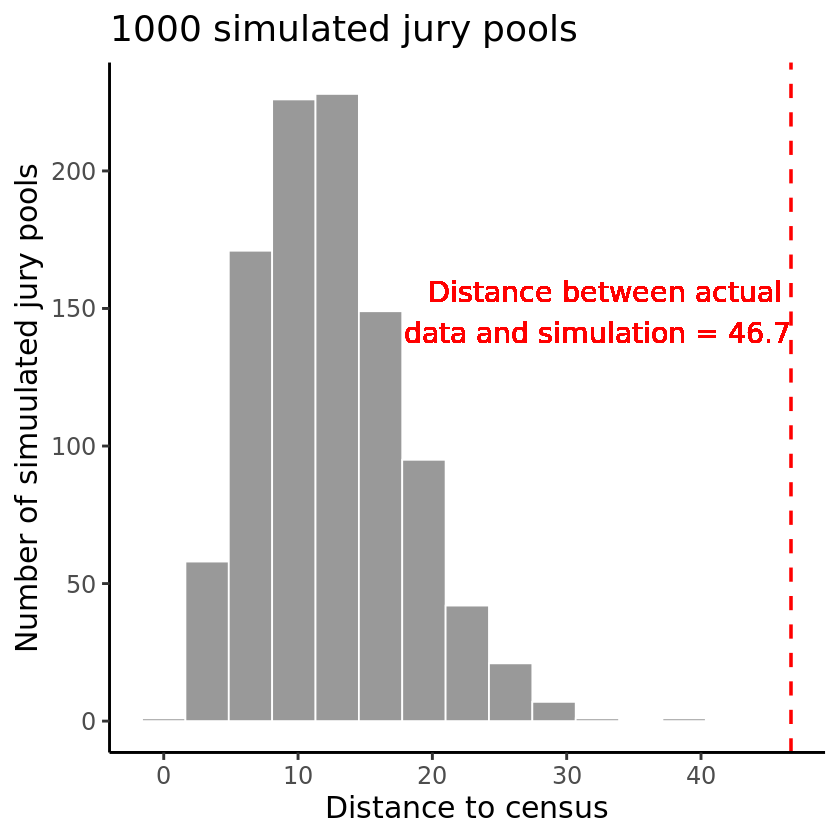

In [49]:
height <- 160

ggplot( proportions, aes( x = distance)) + 
    geom_histogram( bins = 15, color='white', fill='grey60') +
    geom_vline(aes(xintercept=observed_distance), color="red", linetype="dashed", size=1) +
    geom_text(aes(x=observed_distance, 
                  label=paste0('Distance between actual \n data and simulation = ',round(observed_distance,2)), 
                  y=height), 
              color="red", hjust = 1, vjust=1, size = 6) +
    labs(title='1000 simulated jury pools',
        x = 'Distance to census'
        y = 'Number of simuulated jury pools'
        ) +
    theme_classic(base_size = 18)

p-value is significantly less than 0.05, so we conclude that the difference been the jury demographics and the census demographics is **not due to randomness**.